# 第6章 グラフニューラルネットワーク

In [ ]:
# 依存ライブラリのインストール
!pip uninstall -y fastai torch torchaudio torchdata torchtext torchvision
!pip install torch==2.0.0+cpu --index-url https://download.pytorch.org/whl/cpu
!pip install torch-cluster torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

# 必要なライブラリのインストール
!pip install torch-geometric==2.3.1

Found existing installation: fastai 2.7.18
Uninstalling fastai-2.7.18:
  Successfully uninstalled fastai-2.7.18
Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchaudio 2.5.1+cu124
Uninstalling torchaudio-2.5.1+cu124:
  Successfully uninstalled torchaudio-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 MB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
timm 1.0.14 requires torchvision, which is not installed.
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# 必要なライブラリのインポート
from torch_geometric.datasets import Planetoid

# torch_geometric の Dataset としてダウンロード
dataset = Planetoid(root="./dataset", name="Cora", split="full")

Processing...
Done!


In [ ]:
from torch_geometric.transforms import RandomNodeSplit

# ノードを学習データとテストデータに分割
node_splitter = RandomNodeSplit(
    split="train_rest",
    num_splits=1,
    num_val=0.0,
    num_test=0.4,
    key="y",
)
splitted_data = node_splitter(dataset._data)
print(splitted_data.node_attrs())
print(splitted_data.train_mask)
print(splitted_data.test_mask)

['x', 'y', 'train_mask', 'test_mask', 'val_mask']
tensor([False, False,  True,  ..., False,  True,  True])
tensor([ True,  True, False,  ...,  True, False, False])


## 6.8.1 GNN による論文の技術領域の分類

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, Sequential


# GCNモデルの定義
class GCN(torch.nn.Module):

    def __init__(
        self,
        num_node_features: int,
        projection_dim: int,
        num_classes: int,
    ) -> None:
        super().__init__()
        self.conv1 = GCNConv(num_node_features, projection_dim)
        self.conv2 = GCNConv(projection_dim, num_classes)

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
# GCNモデルのインスタンス化
device = "cuda" if torch.cuda.is_available() else "cpu"
gcn_model = GCN(
    num_node_features=dataset.num_node_features,
    projection_dim=64,
    num_classes=dataset.num_classes,
).to(device)

# 最適化アルゴリズムの選択
gcn_optimizer = torch.optim.Adam(list(gcn_model.parameters()), lr=0.01)

In [ ]:
from tqdm import tqdm


# GCNの学習を行う関数の定義
def train_gcn() -> float:
    gcn_model.train()
    total_loss = 0.0
    gcn_optimizer.zero_grad()
    out = gcn_model(splitted_data)
    loss = F.cross_entropy(
        out[splitted_data.train_mask],
        splitted_data.y[splitted_data.train_mask],
    )
    loss.backward()
    gcn_optimizer.step()
    return loss.item()


# GCNの学習の実行
for epoch in tqdm(range(1, 201)):
    loss = train_gcn()
    print(f"train loss : {loss:.4f}")

  0%|          | 0/200 [00:00<?, ?it/s]

train loss : 1.9526


  1%|          | 2/200 [00:00<00:13, 14.65it/s]

train loss : 1.7303
train loss : 1.5230
train loss : 1.3035


  4%|▍         | 8/200 [00:00<00:12, 14.89it/s]

train loss : 1.1007
train loss : 0.9248
train loss : 0.7880
train loss : 0.6664


  6%|▋         | 13/200 [00:00<00:10, 18.34it/s]

train loss : 0.5690
train loss : 0.4959
train loss : 0.4281
train loss : 0.3887
train loss : 0.3621


  8%|▊         | 16/200 [00:00<00:09, 18.92it/s]

train loss : 0.3317
train loss : 0.3017
train loss : 0.2783
train loss : 0.2799


 10%|█         | 20/200 [00:01<00:10, 17.88it/s]

train loss : 0.2583
train loss : 0.2401
train loss : 0.2259
train loss : 0.2180


 12%|█▎        | 25/200 [00:01<00:09, 18.08it/s]

train loss : 0.2127
train loss : 0.1948
train loss : 0.1899
train loss : 0.1825


 14%|█▎        | 27/200 [00:01<00:11, 15.61it/s]

train loss : 0.1807
train loss : 0.1718
train loss : 0.1696


 16%|█▌        | 31/200 [00:01<00:11, 14.65it/s]

train loss : 0.1515
train loss : 0.1565
train loss : 0.1484


 16%|█▋        | 33/200 [00:02<00:11, 15.16it/s]

train loss : 0.1400
train loss : 0.1374
train loss : 0.1282
train loss : 0.1311


 18%|█▊        | 37/200 [00:02<00:11, 14.13it/s]

train loss : 0.1188
train loss : 0.1221


 20%|█▉        | 39/200 [00:02<00:12, 12.99it/s]

train loss : 0.1187
train loss : 0.1155
train loss : 0.1126


 22%|██▏       | 43/200 [00:02<00:12, 12.28it/s]

train loss : 0.1047
train loss : 0.1053
train loss : 0.0937


 22%|██▎       | 45/200 [00:03<00:12, 12.63it/s]

train loss : 0.0993
train loss : 0.0969
train loss : 0.0910


 24%|██▎       | 47/200 [00:03<00:12, 12.73it/s]

train loss : 0.0917
train loss : 0.0914


 24%|██▍       | 49/200 [00:03<00:13, 10.99it/s]

train loss : 0.0856
train loss : 0.0902
train loss : 0.0799


 26%|██▋       | 53/200 [00:03<00:13, 11.27it/s]

train loss : 0.0846
train loss : 0.0829


 28%|██▊       | 55/200 [00:04<00:15,  9.63it/s]

train loss : 0.0832
train loss : 0.0825


 28%|██▊       | 57/200 [00:04<00:14,  9.65it/s]

train loss : 0.0760
train loss : 0.0723


 30%|██▉       | 59/200 [00:04<00:14,  9.94it/s]

train loss : 0.0716
train loss : 0.0713


 30%|███       | 61/200 [00:04<00:14,  9.42it/s]

train loss : 0.0705
train loss : 0.0738
train loss : 0.0675


 32%|███▏      | 63/200 [00:04<00:13, 10.15it/s]

train loss : 0.0681
train loss : 0.0626


 33%|███▎      | 66/200 [00:05<00:16,  8.35it/s]

train loss : 0.0624
train loss : 0.0595


 34%|███▍      | 68/200 [00:05<00:18,  7.12it/s]

train loss : 0.0599
train loss : 0.0609


 35%|███▌      | 70/200 [00:05<00:17,  7.30it/s]

train loss : 0.0593
train loss : 0.0550


 36%|███▌      | 72/200 [00:06<00:17,  7.37it/s]

train loss : 0.0582
train loss : 0.0531


 37%|███▋      | 74/200 [00:06<00:17,  7.39it/s]

train loss : 0.0533
train loss : 0.0515


 38%|███▊      | 76/200 [00:06<00:18,  6.79it/s]

train loss : 0.0516
train loss : 0.0508


 39%|███▉      | 78/200 [00:07<00:17,  7.14it/s]

train loss : 0.0513
train loss : 0.0520


 40%|███▉      | 79/200 [00:07<00:16,  7.51it/s]

train loss : 0.0499
train loss : 0.0473


 42%|████▏     | 83/200 [00:07<00:13,  8.94it/s]

train loss : 0.0480
train loss : 0.0500
train loss : 0.0483


 44%|████▎     | 87/200 [00:07<00:09, 11.77it/s]

train loss : 0.0457
train loss : 0.0401
train loss : 0.0448
train loss : 0.0434


 44%|████▍     | 89/200 [00:07<00:08, 12.85it/s]

train loss : 0.0379
train loss : 0.0432
train loss : 0.0451


 46%|████▋     | 93/200 [00:08<00:07, 13.66it/s]

train loss : 0.0428
train loss : 0.0377
train loss : 0.0385


 48%|████▊     | 97/200 [00:08<00:07, 13.85it/s]

train loss : 0.0463
train loss : 0.0397
train loss : 0.0363
train loss : 0.0393


 50%|████▉     | 99/200 [00:08<00:07, 13.03it/s]

train loss : 0.0373
train loss : 0.0373


 50%|█████     | 101/200 [00:08<00:09, 10.68it/s]

train loss : 0.0342
train loss : 0.0374
train loss : 0.0373


 52%|█████▏    | 104/200 [00:09<00:13,  7.15it/s]

train loss : 0.0348
train loss : 0.0330


 53%|█████▎    | 106/200 [00:09<00:10,  8.64it/s]

train loss : 0.0342
train loss : 0.0340


 54%|█████▍    | 108/200 [00:10<00:11,  8.25it/s]

train loss : 0.0346
train loss : 0.0334
train loss : 0.0315


 56%|█████▌    | 112/200 [00:10<00:08, 10.26it/s]

train loss : 0.0305
train loss : 0.0312
train loss : 0.0345


 57%|█████▋    | 114/200 [00:10<00:07, 10.94it/s]

train loss : 0.0332
train loss : 0.0302
train loss : 0.0305


 59%|█████▉    | 118/200 [00:10<00:06, 12.36it/s]

train loss : 0.0334
train loss : 0.0289
train loss : 0.0283


 60%|██████    | 120/200 [00:10<00:07, 11.27it/s]

train loss : 0.0294
train loss : 0.0302
train loss : 0.0310


 62%|██████▏   | 124/200 [00:11<00:05, 13.05it/s]

train loss : 0.0268
train loss : 0.0266
train loss : 0.0288
train loss : 0.0290


 64%|██████▍   | 128/200 [00:11<00:05, 13.32it/s]

train loss : 0.0285
train loss : 0.0287
train loss : 0.0250


 66%|██████▌   | 132/200 [00:11<00:04, 14.12it/s]

train loss : 0.0280
train loss : 0.0296
train loss : 0.0261
train loss : 0.0270


 68%|██████▊   | 136/200 [00:12<00:04, 14.61it/s]

train loss : 0.0302
train loss : 0.0243
train loss : 0.0236
train loss : 0.0260


 69%|██████▉   | 138/200 [00:12<00:04, 14.50it/s]

train loss : 0.0247
train loss : 0.0224
train loss : 0.0234


 70%|███████   | 140/200 [00:12<00:04, 13.01it/s]

train loss : 0.0278
train loss : 0.0219
train loss : 0.0248

 72%|███████▏  | 144/200 [00:12<00:04, 12.60it/s]


train loss : 0.0283
train loss : 0.0233
train loss : 0.0237


 74%|███████▍  | 148/200 [00:12<00:03, 14.87it/s]

train loss : 0.0209
train loss : 0.0270
train loss : 0.0236
train loss : 0.0235


 76%|███████▌  | 152/200 [00:13<00:03, 15.62it/s]

train loss : 0.0205
train loss : 0.0225
train loss : 0.0219
train loss : 0.0222


 78%|███████▊  | 156/200 [00:13<00:02, 16.96it/s]

train loss : 0.0175
train loss : 0.0201
train loss : 0.0185
train loss : 0.0212


 80%|████████  | 160/200 [00:13<00:02, 14.28it/s]

train loss : 0.0205
train loss : 0.0201
train loss : 0.0193


 81%|████████  | 162/200 [00:13<00:02, 14.37it/s]

train loss : 0.0177
train loss : 0.0182
train loss : 0.0203


 83%|████████▎ | 166/200 [00:14<00:02, 12.87it/s]

train loss : 0.0197
train loss : 0.0214
train loss : 0.0203


 84%|████████▍ | 168/200 [00:14<00:02, 13.66it/s]

train loss : 0.0167
train loss : 0.0194


 85%|████████▌ | 170/200 [00:14<00:02, 10.08it/s]

train loss : 0.0179
train loss : 0.0192


 86%|████████▌ | 172/200 [00:14<00:02, 10.52it/s]

train loss : 0.0167
train loss : 0.0182
train loss : 0.0163


 87%|████████▋ | 174/200 [00:15<00:02, 10.88it/s]

train loss : 0.0148
train loss : 0.0152


 89%|████████▉ | 178/200 [00:15<00:01, 11.28it/s]

train loss : 0.0183
train loss : 0.0190
train loss : 0.0154
train loss : 0.0199


 91%|█████████ | 182/200 [00:15<00:01, 13.52it/s]

train loss : 0.0171
train loss : 0.0164
train loss : 0.0185
train loss : 0.0185


 93%|█████████▎| 186/200 [00:15<00:00, 15.12it/s]

train loss : 0.0168
train loss : 0.0164
train loss : 0.0153
train loss : 0.0162


 95%|█████████▌| 190/200 [00:16<00:00, 13.66it/s]

train loss : 0.0137
train loss : 0.0151
train loss : 0.0166


 96%|█████████▌| 192/200 [00:16<00:00, 13.47it/s]

train loss : 0.0142
train loss : 0.0157
train loss : 0.0175


 98%|█████████▊| 196/200 [00:16<00:00, 13.17it/s]

train loss : 0.0139
train loss : 0.0173
train loss : 0.0132


100%|██████████| 200/200 [00:16<00:00, 11.83it/s]

train loss : 0.0166
train loss : 0.0143
train loss : 0.0174
train loss : 0.0155


In [ ]:
from sklearn.metrics import classification_report

y_true = splitted_data.y[splitted_data.test_mask].numpy()

# 評価データに対する推論
with torch.no_grad():
    gcn_model.eval()
    out = gcn_model(splitted_data)
    y_pred = out.argmax(dim=1)[splitted_data.test_mask]

# 評価結果の表示
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       140
           1       0.78      0.76      0.77        82
           2       0.95      0.90      0.92       189
           3       0.86      0.86      0.86       312
           4       0.86      0.85      0.85       176
           5       0.79      0.83      0.81       121
           6       0.79      0.92      0.85        63

    accuracy                           0.85      1083
   macro avg       0.83      0.84      0.84      1083
weighted avg       0.85      0.85      0.85      1083



## 6.8.2 フィルタの差し替え

In [ ]:
from torch_geometric.nn import SAGEConv


# GraphSAGEモデルの定義
class GraphSAGE(torch.nn.Module):

    def __init__(
        self,
        num_node_features: int,
        projection_dim: int,
        num_classes: int,
    ) -> None:
        super().__init__()
        self.conv1 = SAGEConv(num_node_features, projection_dim)
        self.conv2 = SAGEConv(projection_dim, num_classes)

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
# GraphSAGEモデルのインスタンス化
device = "cuda" if torch.cuda.is_available() else "cpu"
sage_model = GraphSAGE(
    num_node_features=dataset.num_node_features,
    projection_dim=64,
    num_classes=dataset.num_classes,
).to(device)
sage_optimizer = torch.optim.Adam(list(sage_model.parameters()), lr=0.01)

In [ ]:
# GraphSAGEモデルの学習を行う関数の定義
def train_sage() -> float:
    sage_model.train()
    total_loss = 0
    sage_optimizer.zero_grad()
    out = sage_model(splitted_data)
    loss = F.cross_entropy(
        out[splitted_data.train_mask],
        splitted_data.y[splitted_data.train_mask],
    )
    loss.backward()
    sage_optimizer.step()
    return loss.item()


# GraphSAGEモデルの学習の実行
for epoch in tqdm(range(1, 201)):
    loss = train_sage()
    print(f"train loss : {loss:.4f}")


  0%|          | 1/200 [00:00<00:55,  3.58it/s]

train loss : 1.9804


  1%|          | 2/200 [00:00<00:49,  4.02it/s]

train loss : 1.6637


  2%|▏         | 3/200 [00:00<00:47,  4.19it/s]

train loss : 1.3948


  2%|▏         | 4/200 [00:00<00:45,  4.28it/s]

train loss : 1.0890


  2%|▎         | 5/200 [00:01<00:46,  4.22it/s]

train loss : 0.8375


  3%|▎         | 6/200 [00:01<00:49,  3.92it/s]

train loss : 0.6384


  4%|▎         | 7/200 [00:01<00:55,  3.46it/s]

train loss : 0.4732


  4%|▍         | 8/200 [00:02<01:06,  2.89it/s]

train loss : 0.3742


  4%|▍         | 9/200 [00:02<01:01,  3.09it/s]

train loss : 0.3100


  5%|▌         | 10/200 [00:02<00:55,  3.43it/s]

train loss : 0.2600


  6%|▌         | 11/200 [00:03<00:56,  3.35it/s]

train loss : 0.2181


  6%|▌         | 12/200 [00:03<00:58,  3.22it/s]

train loss : 0.1987


  6%|▋         | 13/200 [00:03<01:03,  2.94it/s]

train loss : 0.1748


  7%|▋         | 14/200 [00:04<00:58,  3.16it/s]

train loss : 0.1501


  8%|▊         | 16/200 [00:04<00:48,  3.81it/s]

train loss : 0.1301
train loss : 0.1169


  8%|▊         | 17/200 [00:04<00:53,  3.45it/s]

train loss : 0.0981


 10%|▉         | 19/200 [00:05<00:46,  3.86it/s]

train loss : 0.0900
train loss : 0.0821


 10%|█         | 20/200 [00:05<00:44,  4.00it/s]

train loss : 0.0623


 11%|█         | 22/200 [00:06<00:40,  4.37it/s]

train loss : 0.0617
train loss : 0.0431


 12%|█▏        | 24/200 [00:06<00:34,  5.11it/s]

train loss : 0.0533
train loss : 0.0389


 13%|█▎        | 26/200 [00:06<00:28,  6.00it/s]

train loss : 0.0351
train loss : 0.0305


 14%|█▍        | 28/200 [00:06<00:25,  6.71it/s]

train loss : 0.0244
train loss : 0.0244


 15%|█▌        | 30/200 [00:07<00:24,  6.90it/s]

train loss : 0.0241
train loss : 0.0204


 16%|█▌        | 32/200 [00:07<00:22,  7.36it/s]

train loss : 0.0192
train loss : 0.0177


 17%|█▋        | 34/200 [00:07<00:23,  7.12it/s]

train loss : 0.0172
train loss : 0.0159


 18%|█▊        | 36/200 [00:08<00:23,  7.03it/s]

train loss : 0.0139
train loss : 0.0171


 19%|█▉        | 38/200 [00:08<00:22,  7.23it/s]

train loss : 0.0089
train loss : 0.0108


 20%|██        | 40/200 [00:08<00:22,  7.22it/s]

train loss : 0.0102
train loss : 0.0128


 21%|██        | 42/200 [00:08<00:22,  6.87it/s]

train loss : 0.0101
train loss : 0.0072


 22%|██▏       | 44/200 [00:09<00:22,  7.07it/s]

train loss : 0.0085
train loss : 0.0083


 23%|██▎       | 46/200 [00:09<00:20,  7.47it/s]

train loss : 0.0077
train loss : 0.0076


 24%|██▍       | 48/200 [00:09<00:18,  8.15it/s]

train loss : 0.0066
train loss : 0.0054


 25%|██▌       | 50/200 [00:09<00:18,  8.31it/s]

train loss : 0.0051
train loss : 0.0051


 26%|██▌       | 52/200 [00:10<00:16,  8.77it/s]

train loss : 0.0052
train loss : 0.0055


 26%|██▋       | 53/200 [00:10<00:18,  8.11it/s]

train loss : 0.0041
train loss : 0.0062

 28%|██▊       | 55/200 [00:10<00:22,  6.44it/s]


train loss : 0.0056


 28%|██▊       | 57/200 [00:11<00:24,  5.72it/s]

train loss : 0.0052
train loss : 0.0067


 30%|██▉       | 59/200 [00:11<00:25,  5.54it/s]

train loss : 0.0045
train loss : 0.0045


 30%|███       | 61/200 [00:11<00:24,  5.65it/s]

train loss : 0.0026
train loss : 0.0034


 32%|███▏      | 63/200 [00:12<00:25,  5.32it/s]

train loss : 0.0035
train loss : 0.0056


 32%|███▎      | 65/200 [00:12<00:24,  5.43it/s]

train loss : 0.0036
train loss : 0.0052


 34%|███▎      | 67/200 [00:12<00:25,  5.32it/s]

train loss : 0.0029
train loss : 0.0037


 34%|███▍      | 69/200 [00:13<00:23,  5.49it/s]

train loss : 0.0029
train loss : 0.0043


 35%|███▌      | 70/200 [00:13<00:24,  5.36it/s]

train loss : 0.0025


 36%|███▌      | 72/200 [00:13<00:24,  5.29it/s]

train loss : 0.0053
train loss : 0.0050


 37%|███▋      | 74/200 [00:14<00:22,  5.63it/s]

train loss : 0.0031
train loss : 0.0027


 38%|███▊      | 76/200 [00:14<00:19,  6.25it/s]

train loss : 0.0030
train loss : 0.0031


 39%|███▉      | 78/200 [00:14<00:18,  6.48it/s]

train loss : 0.0036
train loss : 0.0026


 40%|████      | 80/200 [00:15<00:20,  5.91it/s]

train loss : 0.0038
train loss : 0.0028


 41%|████      | 82/200 [00:15<00:21,  5.57it/s]

train loss : 0.0023
train loss : 0.0018


 42%|████▏     | 84/200 [00:15<00:20,  5.71it/s]

train loss : 0.0023
train loss : 0.0025


 43%|████▎     | 86/200 [00:16<00:18,  6.00it/s]

train loss : 0.0037
train loss : 0.0025


 44%|████▍     | 88/200 [00:16<00:18,  6.12it/s]

train loss : 0.0026
train loss : 0.0021


 45%|████▌     | 90/200 [00:16<00:17,  6.27it/s]

train loss : 0.0025
train loss : 0.0018


 46%|████▌     | 92/200 [00:17<00:17,  6.05it/s]

train loss : 0.0027
train loss : 0.0021


 47%|████▋     | 94/200 [00:17<00:17,  5.93it/s]

train loss : 0.0021
train loss : 0.0026


 48%|████▊     | 96/200 [00:17<00:18,  5.78it/s]

train loss : 0.0015
train loss : 0.0017


 49%|████▉     | 98/200 [00:18<00:19,  5.19it/s]

train loss : 0.0018
train loss : 0.0017


 50%|█████     | 100/200 [00:18<00:17,  5.71it/s]

train loss : 0.0024
train loss : 0.0019


 51%|█████     | 102/200 [00:18<00:15,  6.23it/s]

train loss : 0.0017
train loss : 0.0019


 52%|█████▏    | 104/200 [00:19<00:14,  6.70it/s]

train loss : 0.0016
train loss : 0.0014


 53%|█████▎    | 106/200 [00:19<00:13,  7.00it/s]

train loss : 0.0017
train loss : 0.0032


 54%|█████▍    | 108/200 [00:19<00:12,  7.16it/s]

train loss : 0.0015
train loss : 0.0015


 55%|█████▌    | 110/200 [00:19<00:12,  7.05it/s]

train loss : 0.0029
train loss : 0.0019


 56%|█████▌    | 112/200 [00:20<00:12,  7.19it/s]

train loss : 0.0012
train loss : 0.0031


 57%|█████▋    | 114/200 [00:20<00:11,  7.36it/s]

train loss : 0.0013
train loss : 0.0020


 58%|█████▊    | 116/200 [00:20<00:10,  8.02it/s]

train loss : 0.0021
train loss : 0.0019


 59%|█████▉    | 118/200 [00:20<00:09,  8.46it/s]

train loss : 0.0015
train loss : 0.0016


 60%|██████    | 120/200 [00:21<00:09,  8.41it/s]

train loss : 0.0021
train loss : 0.0011


 61%|██████    | 122/200 [00:21<00:08,  8.67it/s]

train loss : 0.0013
train loss : 0.0026


 62%|██████▏   | 124/200 [00:21<00:09,  8.37it/s]

train loss : 0.0012
train loss : 0.0015


 63%|██████▎   | 126/200 [00:21<00:09,  7.81it/s]

train loss : 0.0017
train loss : 0.0012


 64%|██████▍   | 128/200 [00:22<00:09,  7.62it/s]

train loss : 0.0016
train loss : 0.0020


 65%|██████▌   | 130/200 [00:22<00:09,  7.47it/s]

train loss : 0.0015
train loss : 0.0015


 66%|██████▌   | 132/200 [00:22<00:08,  7.67it/s]

train loss : 0.0007
train loss : 0.0010


 67%|██████▋   | 134/200 [00:22<00:07,  8.27it/s]

train loss : 0.0021
train loss : 0.0009


 68%|██████▊   | 136/200 [00:23<00:07,  8.46it/s]

train loss : 0.0018
train loss : 0.0021


 69%|██████▉   | 138/200 [00:23<00:07,  8.68it/s]

train loss : 0.0011
train loss : 0.0010


 70%|███████   | 140/200 [00:23<00:06,  8.72it/s]

train loss : 0.0019
train loss : 0.0012


 71%|███████   | 142/200 [00:23<00:06,  8.73it/s]

train loss : 0.0016
train loss : 0.0011


 72%|███████▏  | 144/200 [00:24<00:07,  7.89it/s]

train loss : 0.0022
train loss : 0.0016


 73%|███████▎  | 146/200 [00:24<00:07,  6.90it/s]

train loss : 0.0010
train loss : 0.0009


 74%|███████▎  | 147/200 [00:24<00:08,  6.37it/s]

train loss : 0.0008


 74%|███████▍  | 149/200 [00:25<00:09,  5.60it/s]

train loss : 0.0012
train loss : 0.0015


 76%|███████▌  | 151/200 [00:25<00:08,  5.49it/s]

train loss : 0.0013
train loss : 0.0011


 76%|███████▌  | 152/200 [00:25<00:09,  5.33it/s]

train loss : 0.0012


 76%|███████▋  | 153/200 [00:25<00:09,  5.10it/s]

train loss : 0.0013


 77%|███████▋  | 154/200 [00:26<00:09,  5.03it/s]

train loss : 0.0013


 78%|███████▊  | 156/200 [00:26<00:08,  5.06it/s]

train loss : 0.0016
train loss : 0.0012


 79%|███████▉  | 158/200 [00:26<00:07,  5.38it/s]

train loss : 0.0018
train loss : 0.0014


 80%|████████  | 160/200 [00:27<00:06,  5.72it/s]

train loss : 0.0023
train loss : 0.0021


 81%|████████  | 162/200 [00:27<00:06,  5.75it/s]

train loss : 0.0010
train loss : 0.0017


 82%|████████▏ | 164/200 [00:27<00:05,  6.17it/s]

train loss : 0.0010
train loss : 0.0011


 83%|████████▎ | 166/200 [00:28<00:04,  7.22it/s]

train loss : 0.0007
train loss : 0.0013


 84%|████████▍ | 168/200 [00:28<00:04,  7.68it/s]

train loss : 0.0007
train loss : 0.0010


 85%|████████▌ | 170/200 [00:28<00:03,  8.20it/s]

train loss : 0.0018
train loss : 0.0007


 86%|████████▌ | 172/200 [00:28<00:03,  8.41it/s]

train loss : 0.0020
train loss : 0.0032


 87%|████████▋ | 174/200 [00:28<00:02,  8.84it/s]

train loss : 0.0007
train loss : 0.0011


 88%|████████▊ | 176/200 [00:29<00:02,  8.60it/s]

train loss : 0.0009
train loss : 0.0013


 89%|████████▉ | 178/200 [00:29<00:02,  8.50it/s]

train loss : 0.0009
train loss : 0.0009


 90%|█████████ | 180/200 [00:29<00:02,  8.68it/s]

train loss : 0.0005
train loss : 0.0011


 91%|█████████ | 182/200 [00:29<00:02,  7.70it/s]

train loss : 0.0013
train loss : 0.0007


 92%|█████████▏| 184/200 [00:30<00:02,  7.67it/s]

train loss : 0.0012
train loss : 0.0009


 93%|█████████▎| 186/200 [00:30<00:01,  7.34it/s]

train loss : 0.0016
train loss : 0.0008


 94%|█████████▍| 188/200 [00:30<00:01,  7.11it/s]

train loss : 0.0010
train loss : 0.0006


 95%|█████████▌| 190/200 [00:31<00:01,  7.86it/s]

train loss : 0.0008
train loss : 0.0010


 96%|█████████▌| 192/200 [00:31<00:00,  8.36it/s]

train loss : 0.0011
train loss : 0.0015


 97%|█████████▋| 194/200 [00:31<00:00,  8.39it/s]

train loss : 0.0013
train loss : 0.0014


 98%|█████████▊| 196/200 [00:31<00:00,  8.26it/s]

train loss : 0.0011
train loss : 0.0011


 99%|█████████▉| 198/200 [00:31<00:00,  8.16it/s]

train loss : 0.0010
train loss : 0.0018


100%|██████████| 200/200 [00:32<00:00,  6.20it/s]

train loss : 0.0006
train loss : 0.0005


In [ ]:
from sklearn.metrics import classification_report
from sklearn.utils.validation import column_or_1d

y_true = column_or_1d(splitted_data.y[splitted_data.test_mask].numpy())

# 評価データに対する推論
with torch.no_grad():
    sage_model.eval()
    out = sage_model(splitted_data)
    y_pred = out.argmax(dim=1)[splitted_data.test_mask]

# 評価結果の表示
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       140
           1       0.86      0.78      0.82        82
           2       0.96      0.93      0.94       189
           3       0.85      0.92      0.88       312
           4       0.91      0.85      0.88       176
           5       0.84      0.88      0.86       121
           6       0.87      0.92      0.89        63

    accuracy                           0.87      1083
   macro avg       0.87      0.86      0.87      1083
weighted avg       0.87      0.87      0.87      1083



## 6.8.3 GNNによる論文の引用関係の予測

In [ ]:
from torch_geometric.transforms import RandomLinkSplit

# エッジを学習データとテストデータに分割
link_splitter = RandomLinkSplit(
    num_val=0.0,
    num_test=0.4,
    is_undirected=True,
)
train_data, _, test_data = link_splitter(dataset._data)
print(train_data.edge_label_index.shape)
print(test_data.edge_label_index.shape)

torch.Size([2, 6334])
torch.Size([2, 4222])


In [ ]:
# GCNによる特徴変換の定義
class GCNLayer(torch.nn.Module):

    def __init__(
        self,
        num_node_features: int,
        projection_dim: int,
    ) -> None:
        super().__init__()
        self.conv1 = GCNConv(num_node_features, projection_dim)
        self.conv2 = GCNConv(projection_dim, projection_dim)

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        return self.conv2(x, edge_index)


# リンク予測モデルの定義
class LinkPredModel(torch.nn.Module):

    def __init__(
        self,
        num_node_features: int,
        projection_dim: int,
    ) -> None:
        super().__init__()
        self.gcn_layer = GCNLayer(num_node_features, projection_dim)

    def forward(self, data: Data, edge_label_index: torch.Tensor) -> None:
        x = self.gcn_layer(data)
        x_src = x[edge_label_index[0]]
        x_dst = x[edge_label_index[1]]
        # 内積をシグモイド関数に入力して、0〜1の値に変換
        return F.sigmoid((x_src * x_dst).sum(-1))

In [ ]:
# リンク予測モデルのインスタンス化
device = "cuda" if torch.cuda.is_available() else "cpu"
link_pred_model = LinkPredModel(
    num_node_features=dataset.num_node_features,
    projection_dim=64,
).to(device)

# 最適化アルゴリズムの選択
link_pred_optimizer = torch.optim.Adam(list(link_pred_model.parameters()), lr=0.01)

In [ ]:
from torch_geometric.utils import negative_sampling


# リンク予測モデルを学習する関数の定義
def train_link_pred_model() -> float:
    link_pred_model.train()
    link_pred_optimizer.zero_grad()

    total_loss = 0
    link_pred_optimizer.zero_grad()

    # Negative Samplingによる負例の獲得
    negative_edge_index = negative_sampling(
        edge_index=train_data.edge_index,
        num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1),
        method="sparse",
    )

    # 学習対象のエッジのインデックス
    edge_label_index = torch.cat(
        [train_data.edge_label_index, negative_edge_index],
        dim=-1,
    )

    # 学習対象のエッジのラベル
    # 1は実在するリンク、0はランダムに選ばれたノード間のリンク
    edge_label = torch.cat(
        [
            train_data.edge_label,
            train_data.edge_label.new_zeros(negative_edge_index.size(1)),
        ],
        dim=0,
    )
    out = link_pred_model(train_data, edge_label_index)
    loss = F.binary_cross_entropy(out, edge_label)
    loss.backward()
    link_pred_optimizer.step()
    total_loss += loss.item()
    return total_loss


# リンク予測モデルの学習の実行
for epoch in range(1, 31):
    loss = train_link_pred_model()
    print(f"train loss : {loss:.4f}")

train loss : 0.7132
train loss : 0.8221
train loss : 0.6993
train loss : 0.6950
train loss : 0.6954
train loss : 0.6958
train loss : 0.6939
train loss : 0.6914
train loss : 0.6879
train loss : 0.6829
train loss : 0.6776
train loss : 0.6696
train loss : 0.6606
train loss : 0.6520
train loss : 0.6457
train loss : 0.6443
train loss : 0.6371
train loss : 0.6369
train loss : 0.6361
train loss : 0.6362
train loss : 0.6367
train loss : 0.6273
train loss : 0.6214
train loss : 0.6225
train loss : 0.6182
train loss : 0.6138
train loss : 0.6217
train loss : 0.6126
train loss : 0.6120
train loss : 0.6101


In [ ]:
from sklearn.metrics import roc_auc_score

# 評価データに対する推論
with torch.no_grad():
    link_pred_model.eval()
    out = link_pred_model(test_data, test_data.edge_label_index)
    y_true = test_data.edge_label.numpy()
    y_pred = out.numpy()

# AUCの計算
print(f"AUC : {roc_auc_score(y_true, y_pred):.4f}")

AUC : 0.8340


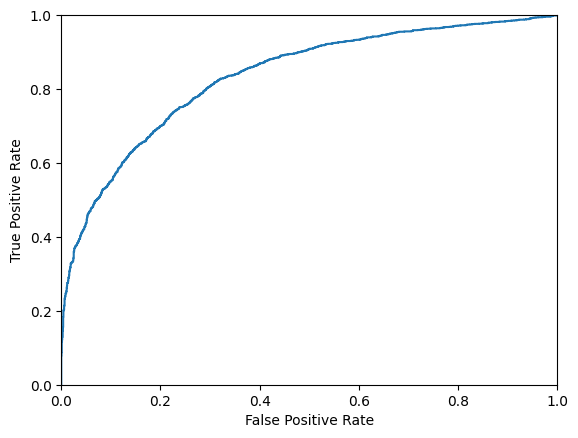

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ROC曲線の描画
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()